In [1]:

!pip install opencv-python-headless tensorflow keras matplotlib ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.4 MB/s eta 0:00:00


In [2]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from google.colab import files
from ultralytics import YOLO
import os


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:

uploaded = files.upload()
video_path = list(uploaded.keys())[0]
cap = cv2.VideoCapture(video_path)


In [3]:

model = YOLO('yolov8n.pt')


In [ ]:

def detect_people_yolo(frame):
    results = model(frame)
    detections = results[0].boxes.data.cpu().numpy()
    people = []
    for det in detections:
        x1, y1, x2, y2, conf, cls = det
        if int(cls) == 0:
            people.append((int(x1), int(y1), int(x2), int(y2), float(conf)))
    return people

entry_line = [(100, 200), (500, 200)]
entry_count = 0

def is_crossing_line(y_center, line_y=200):
    return y_center < line_y + 5 and y_center > line_y - 5

restricted_zone = [(300, 100), (500, 100), (500, 300), (300, 300)]

def is_inside_zone(x1, y1, x2, y2, zone):
    cx = (x1 + x2) // 2
    cy = (y1 + y2) // 2
    return cv2.pointPolygonTest(np.array(zone, np.int32), (cx, cy), False) >= 0

log = []

def log_event(event_type, frame_num, person_id=None):
    log.append({"event": event_type, "frame": frame_num, "person_id": person_id})


In [ ]:

frame_num = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_num += 1
    people = detect_people_yolo(frame)

    for (x1, y1, x2, y2, conf) in people:
        cx, cy = (x1 + x2) // 2, (y1 + y2) // 2

        if is_crossing_line(cy):
            entry_count += 1
            log_event("Entry", frame_num)

        if is_inside_zone(x1, y1, x2, y2, restricted_zone):
            log_event("Intrusion", frame_num)

        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.circle(frame, (cx, cy), 5, (255, 0, 0), -1)

    cv2.line(frame, entry_line[0], entry_line[1], (0, 0, 255), 2)
    cv2.polylines(frame, [np.array(restricted_zone, np.int32)], True, (0, 0, 255), 2)

    cv2.putText(frame, f"Entries: {entry_count}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    cv2_imshow(frame)

cap.release()


In [ ]:

import pandas as pd

df = pd.DataFrame(log)
df.to_csv("event_log.csv", index=False)

files.download("event_log.csv")



### 🖼️ Optional: Detect People in an Image
You can also upload a `.jpg` or `.png` image and run YOLOv8 detection on it.


Saving Screenshot 2025-09-02 163631.png to Screenshot 2025-09-02 163631.png


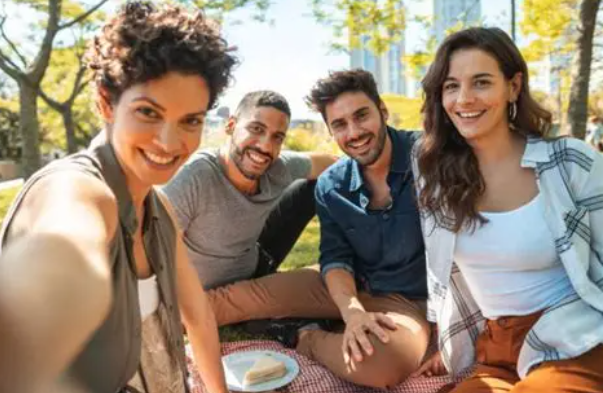

In [4]:

from PIL import Image

uploaded_img = files.upload()
image_path = list(uploaded_img.keys())[0]
image = Image.open(image_path)
image



image 1/1 /content/Screenshot 2025-09-02 163631.png: 448x640 4 persons, 1 bowl, 290.1ms
Speed: 4.4ms preprocess, 290.1ms inference, 2.4ms postprocess per image at shape (1, 3, 448, 640)


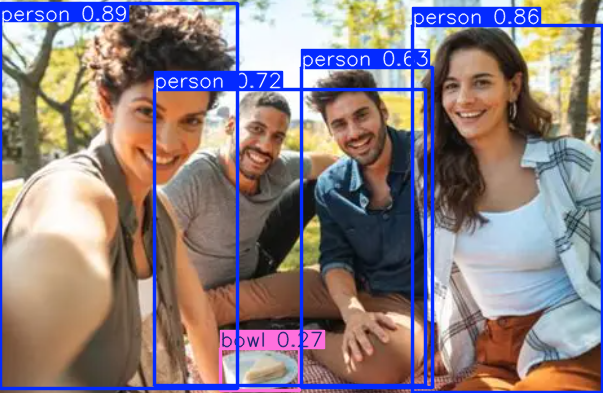

In [6]:

# Run YOLOv8 on the uploaded image
results = model(image_path)
results[0].show()  # Access the first result in the list

In [7]:

# Optional: Print detected people with confidence and coordinates
detections = results[0].boxes.data.cpu().numpy()

for det in detections:
    x1, y1, x2, y2, conf, cls = det
    if int(cls) == 0:  # Class 0 is 'person'
        print(f"Person detected with confidence {conf:.2f} at [{int(x1)}, {int(y1)}, {int(x2)}, {int(y2)}]")


Person detected with confidence 0.89 at [0, 3, 237, 388]
Person detected with confidence 0.86 at [412, 25, 602, 392]
Person detected with confidence 0.72 at [154, 89, 425, 385]
Person detected with confidence 0.63 at [301, 67, 432, 387]
